## Libraries

In [2]:
# basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import shap

## Data Manipulation

In [3]:
mode_allcat = pd.read_csv("../data/mode_allcat.csv")
mode_ordinal = pd.read_csv("../data/mode_ordinal.csv")
nan_allcat = pd.read_csv("../data/nan_allcat.csv")

In [4]:
# change column name for xgboost
mode_allcat = mode_allcat.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(less_than_20)'})
mode_ordinal = mode_ordinal.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(less_than_20)'})
nan_allcat = nan_allcat.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(less_than_20)'})

## Modeling

## Neural Network

Grid search iterative parameter search below. Best performing parameters are: 

  -  "hidden_layer_sizes":[(400,)],
  -  "activation":["relu"],
  -  "solver":["adam"],
  -  "learning_rate":["constant"],
  -  "learning_rate_init": [.01],
  -  "max_iter":[500],
  -  "shuffle":[False],
     


In [20]:
# param to search
nn_param = {
    "hidden_layer_sizes":[150,100,50],
    "activation":["identity"],   #, "logistic", "tanh", "relu"],
    "solver":["sgd"],
    
    "alpha":[0.0001,.001,.01,.1,.3,.5,.7],
    
    "learning_rate":["constant", "invscaling", "adaptive"], #Only used when solver='sgd'
    "learning_rate_init": [.001,.01,.1],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[True,False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrewyaholkovsky/opt/anaconda

KeyboardInterrupt: 

Data 1 best param: MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=50,
              learning_rate_init=0.01, max_iter=500, random_state=7,
              shuffle=False, solver='sgd')
Model AUC (with data 1) = 0.7191506349278826


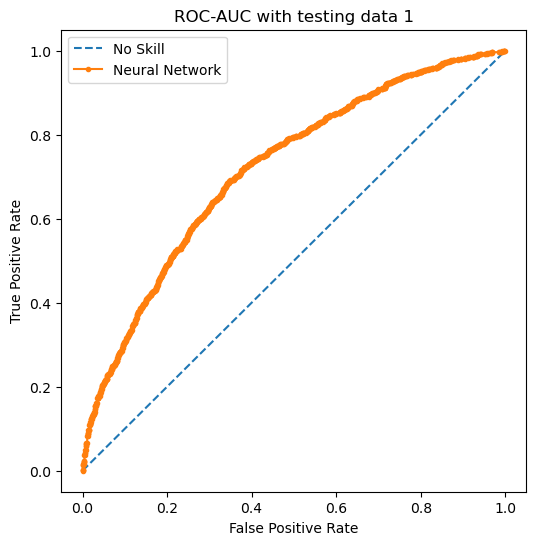

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Data 2 best param: MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=50,
              learning_rate_init=0.01, max_iter=500, random_state=7,
              shuffle=False, solver='sgd')
Model AUC (with data 2) = 0.7250268252591205


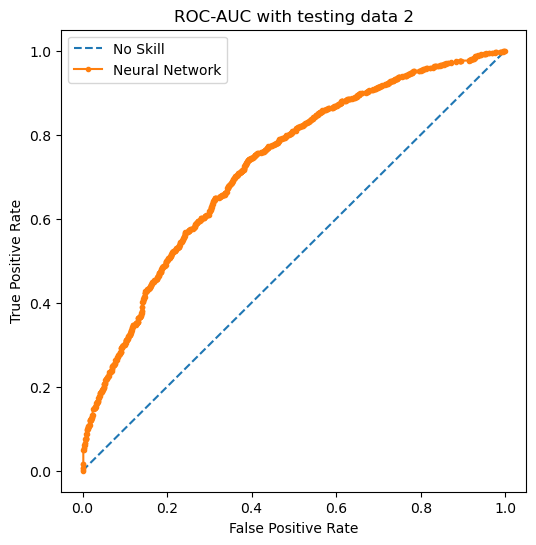

Data 3 best param: MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=50,
              learning_rate_init=0.01, max_iter=500, random_state=7,
              shuffle=False, solver='sgd')
Model AUC (with data 3) = 0.7274753435916168


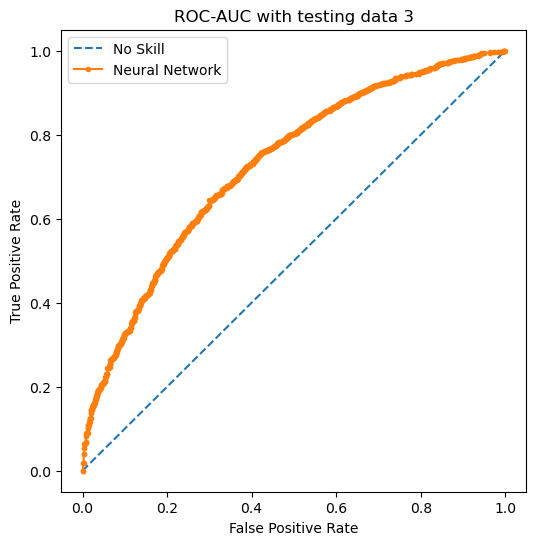

In [27]:
# param to search
nn_param = {
    "hidden_layer_sizes":[50, 100, 150],
    "activation":["logistic"],   #, "logistic", "tanh", "relu"],
    "solver":["sgd"],
    
    "alpha":[.001,.01,.1],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    "learning_rate_init": [.001,.01,1],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Converg

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Converg

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Data 1 best param: MLPClassifier(activation='logistic', alpha=0.5, hidden_layer_sizes=200,
              max_iter=1000, random_state=7, shuffle=False, solver='lbfgs')
Model AUC (with data 1) = 0.753354425723838


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


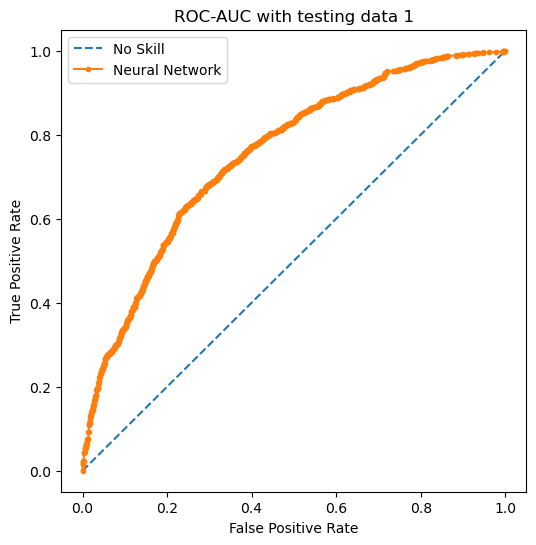

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Converg

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproce

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Data 2 best param: MLPClassifier(activation='logistic', alpha=0.5, hidden_layer_sizes=200,
              max_iter=1000, random_state=7, shuffle=False, solver='lbfgs')
Model AUC (with data 2) = 0.7984145193776033


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


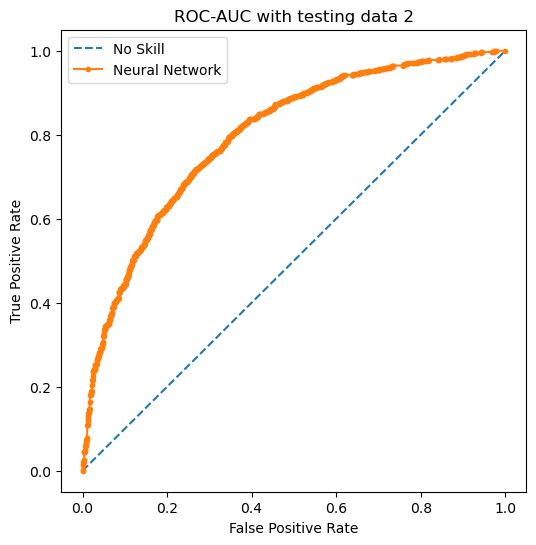

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Converg

Data 3 best param: MLPClassifier(activation='logistic', alpha=0.3, hidden_layer_sizes=100,
              max_iter=1000, random_state=7, shuffle=False, solver='lbfgs')
Model AUC (with data 3) = 0.789772093105845


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


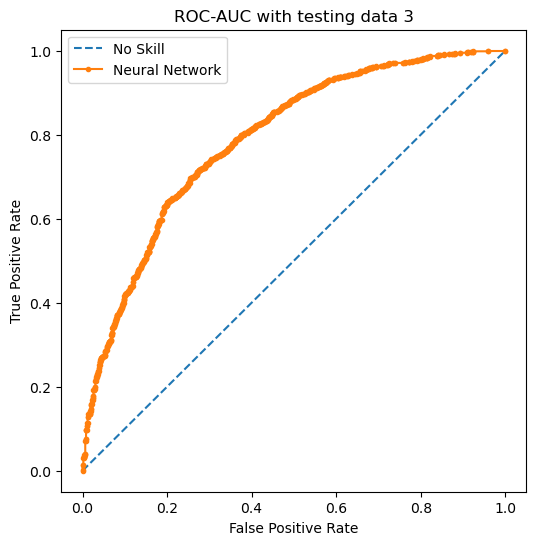

In [41]:
# param to search
nn_param = {
    "hidden_layer_sizes":[100,200],
    "activation":["logistic"],   #, "logistic", "tanh", "relu"],
    "solver":["lbfgs"],
    
    "alpha":[.001,.01,.1,.3,.5],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    #"learning_rate_init": [.001,.01,.1],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[1000],
    "shuffle":[False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

Data 1 best param: MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=100,
              learning_rate_init=0.01, max_iter=500, random_state=7,
              shuffle=False, solver='sgd')
Model AUC (with data 1) = 0.7221052184324409


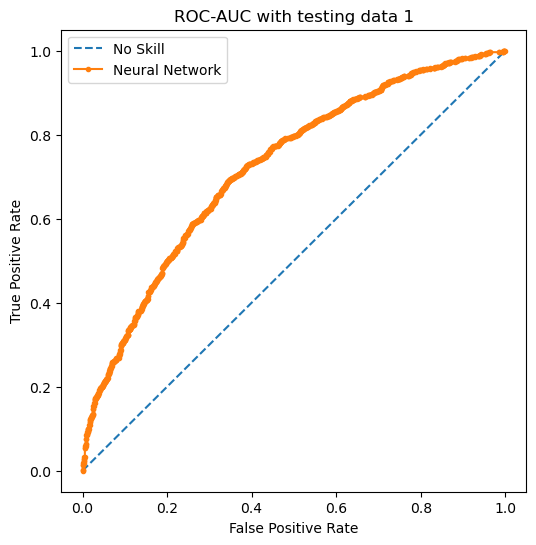

Data 2 best param: MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=100,
              learning_rate_init=0.01, max_iter=500, random_state=7,
              shuffle=False, solver='sgd')
Model AUC (with data 2) = 0.7245480292629967


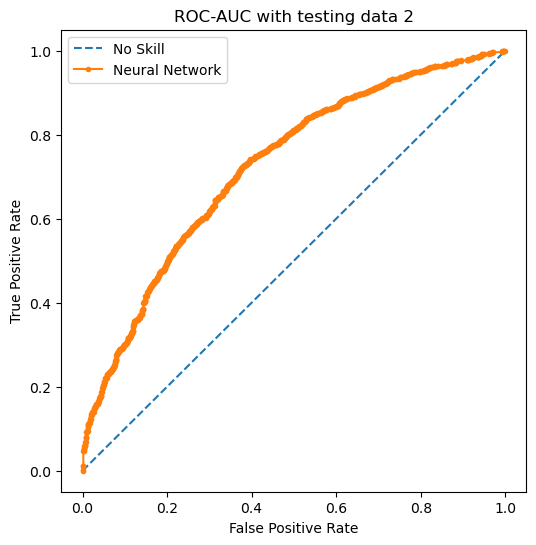

Data 3 best param: MLPClassifier(activation='logistic', alpha=0.1, hidden_layer_sizes=100,
              learning_rate_init=1, max_iter=500, random_state=7, shuffle=False,
              solver='sgd')
Model AUC (with data 3) = 0.7729933057343906


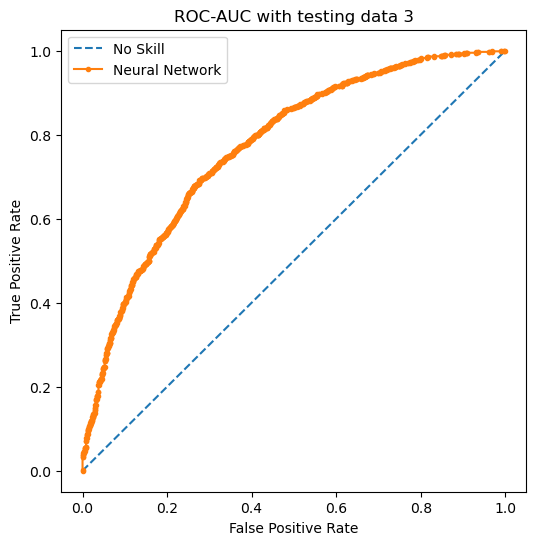

In [43]:
# param to search
nn_param = {
    "hidden_layer_sizes":[100, 150],
    "activation":["logistic"],   #, "logistic", "tanh", "relu"],
    "solver":["sgd"],
    
    "alpha":[.001,.01,.1],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    "learning_rate_init": [.001,.01,1],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

Data 1 best param: MLPClassifier(alpha=0.001, hidden_layer_sizes=100, max_iter=500, random_state=7,
              shuffle=False, solver='sgd')
Model AUC (with data 1) = 0.7436687949307236


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


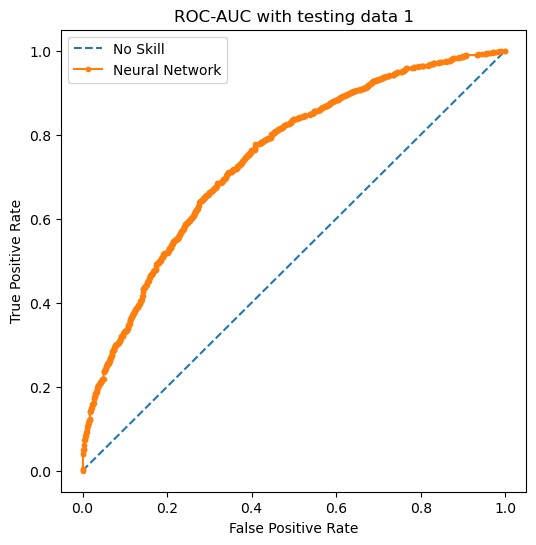

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

Data 2 best param: MLPClassifier(alpha=0.1, hidden_layer_sizes=150, learning_rate_init=0.01,
              max_iter=500, random_state=7, shuffle=False, solver='sgd')
Model AUC (with data 2) = 0.7795404446270845


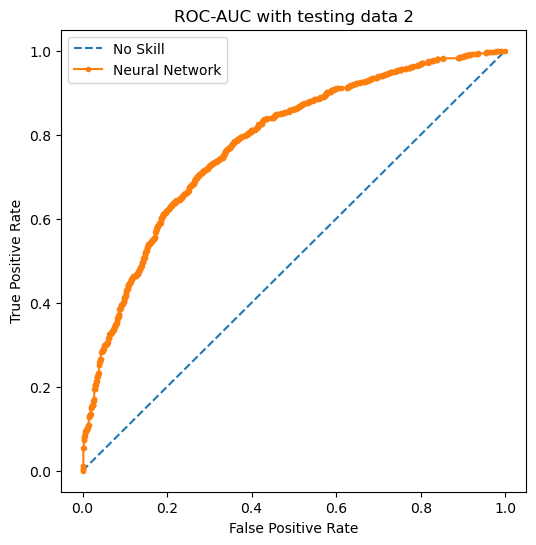

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

Data 3 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=150, learning_rate_init=0.01,
              max_iter=500, random_state=7, solver='sgd')
Model AUC (with data 3) = 0.8309618662770346


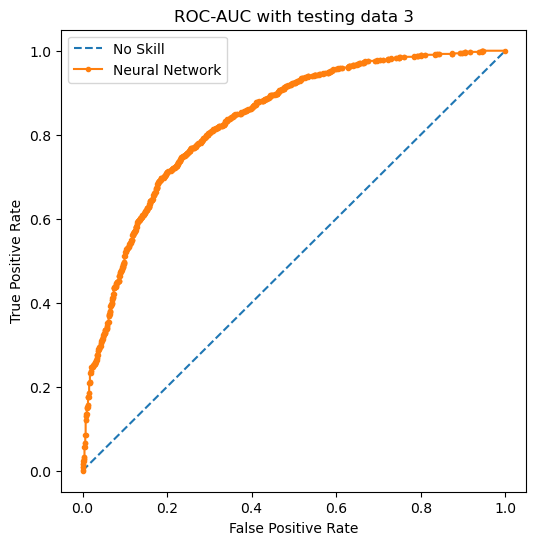

In [45]:
# param to search
nn_param = {
    "hidden_layer_sizes":[100, 150],
    "activation":["logistic", "tanh","relu"],   #, "logistic", "tanh", "relu"],
    "solver":["sgd"],
    
    "alpha":[.0001,.001,.01,.1, .3],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    "learning_rate_init": [.001,.01,.1,.5],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[True,False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal, nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

Data 1 best param: MLPClassifier(activation='tanh', alpha=0.3, hidden_layer_sizes=150,
              learning_rate_init=0.01, max_iter=500, random_state=7,
              shuffle=False, solver='sgd')
Model AUC (with data 1) = 0.8073188565717445


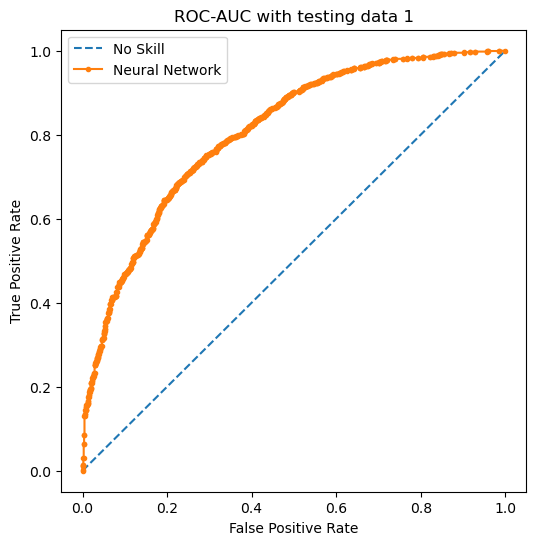

In [47]:
# param to search
nn_param = {
    "hidden_layer_sizes":[150],
    "activation":["tanh"],   #, "tanh","relu"],   #, "logistic", "tanh", "relu"],
    "solver":["sgd"],
    
    "alpha":[.3],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    "learning_rate_init": [.01],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[True,False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_c8592a89acb64989b14ccfd0f68ba981/11335-140591394488720-a49c9e08d6814c639ca1425918e0956d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_c8592a89acb64989b14ccfd0f68ba981/11335-140591394488720-a49c9e08d6814c639ca1425918e0956d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_c8592a89acb64989b14ccfd0f68ba981/11335-140591394488720-a49c9e08d6814c639ca1425918e0956d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_c8592a89acb64989b14ccfd0f68ba981/11335-140591394488720-a49c9e08d6814c639ca1425918e0956d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_c8592a89acb64989b14ccfd0f68ba981/11335-140591394488720-a49c9e08d6814c639ca1425918e0956d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_c8592a89acb64989b14ccfd0f68ba981/11335-140591394488720-a49c9e08d6814c63

Data 1 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=500, learning_rate_init=0.01,
              max_iter=500, random_state=7, solver='sgd')
Model AUC (with data 1) = 0.8359426129704883


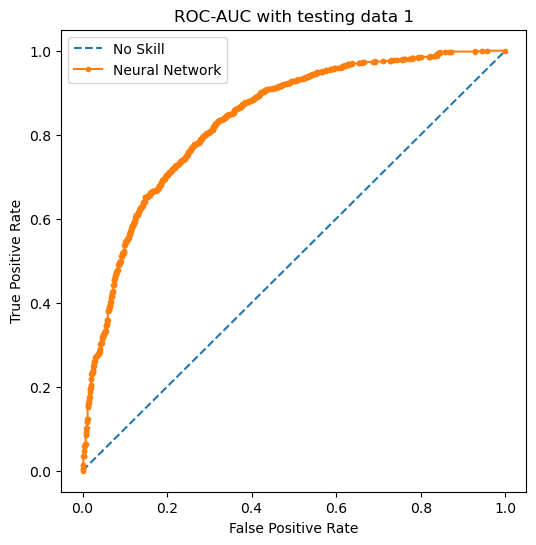

In [12]:
# param to search
nn_param = {
    "hidden_layer_sizes":[300,400,500],
    "activation":["relu"],   #, "tanh","relu"],   #, "logistic", "tanh", "relu"],
    "solver":["sgd"],
    
    "alpha":[.3,.5,.7],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    "learning_rate_init": [.01],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[True,False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_6c32a2a5765e4623bb6b652650695dd4/11335-140591394488720-d3456eead5574fa2be1f10ad4aa4725d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_6c32a2a5765e4623bb6b652650695dd4/11335-140591394488720-d3456eead5574fa2be1f10ad4aa4725d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_6c32a2a5765e4623bb6b652650695dd4/11335-140591394488720-d3456eead5574fa2be1f10ad4aa4725d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_6c32a2a5765e4623bb6b652650695dd4/11335-140591394488720-d3456eead5574fa2be1f10ad4aa4725d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_6c32a2a5765e4623bb6b652650695dd4/11335-140591394488720-d3456eead5574fa2be1f10ad4aa4725d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_6c32a2a5765e4623bb6b652650695dd4/11335-140591394488720-d3456eead5574fa2be1f10ad4aa4725d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_6c32a2a5765e4623bb6b652650695dd4/11335-140591394488720-d3456eead5574fa2be1f10ad4aa4725d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)


Data 1 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=(20, 20, 20),
              learning_rate_init=0.01, max_iter=500, random_state=7)
Model AUC (with data 1) = 0.7567434135427606


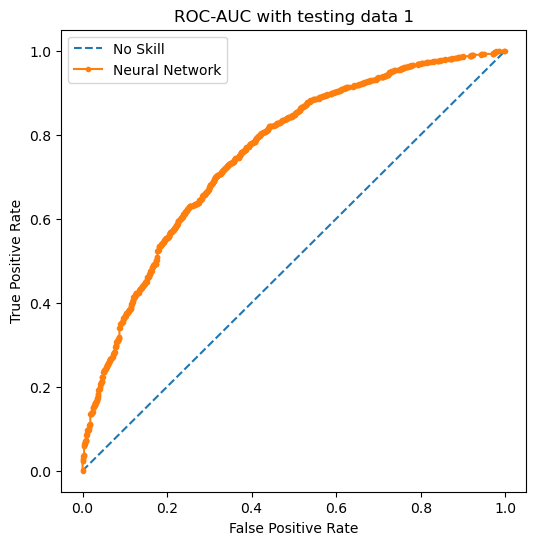

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_dfcdbb90ae1d4c739d311e271db6e0dc/11335-140591394488720-f00c5d69d07d4235a65a89096704a5fa.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_dfcdbb90ae1d4c739d311e271db6e0dc/11335-140591394488720-f00c5d69d07d4235a65a89096704a5fa.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_dfcdbb90ae1d4c739d311e271db6e0dc/11335-140591394488720-f00c5d69d07d4235a65a89096704a5fa.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_dfcdbb90ae1d4c739d311e271db6e0dc/11335-140591394488720-f00c5d69d07d4235a65a89096704a5fa.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_dfcdbb90ae1d4c739d311e271db6e0dc/11335-140591394488720-f00c5d69d07d4235a65a89096704a5fa.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

Data 2 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=(20, 20, 20),
              learning_rate_init=0.01, max_iter=500, random_state=7,
              shuffle=False)
Model AUC (with data 2) = 0.7510669857794419


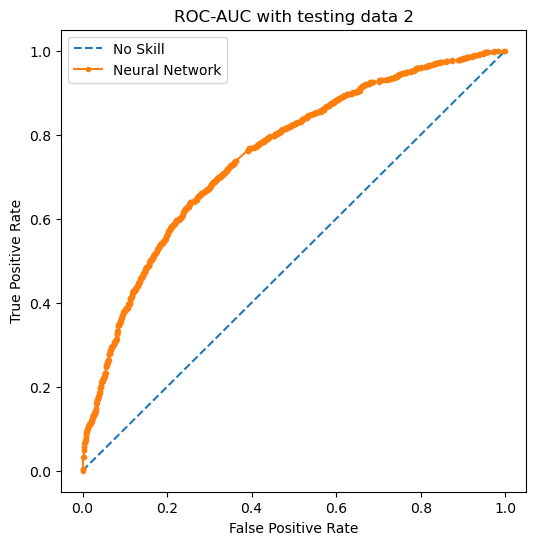

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_9f1a62b93876420d895d21c1af9cb6fa/11335-140591394488720-2f80a921fbac4c72875a31ea4af3ee0d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_9f1a62b93876420d895d21c1af9cb6fa/11335-140591394488720-2f80a921fbac4c72875a31ea4af3ee0d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_9f1a62b93876420d895d21c1af9cb6fa/11335-140591394488720-2f80a921fbac4c72875a31ea4af3ee0d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_9f1a62b93876420d895d21c1af9cb6fa/11335-140591394488720-2f80a921fbac4c72875a31ea4af3ee0d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_9f1a62b93876420d895d21c1af9cb6fa/11335-140591394488720-2f80a921fbac4c72875a31ea4af3ee0d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_9f1a62b93876420d895d21c1af9cb6fa/11335-140591394488720-2f80a921fbac4c72875a31ea4af3ee0d.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

Data 3 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=(30, 30, 30),
              learning_rate_init=0.01, max_iter=500, random_state=7)
Model AUC (with data 3) = 0.8037595949449289


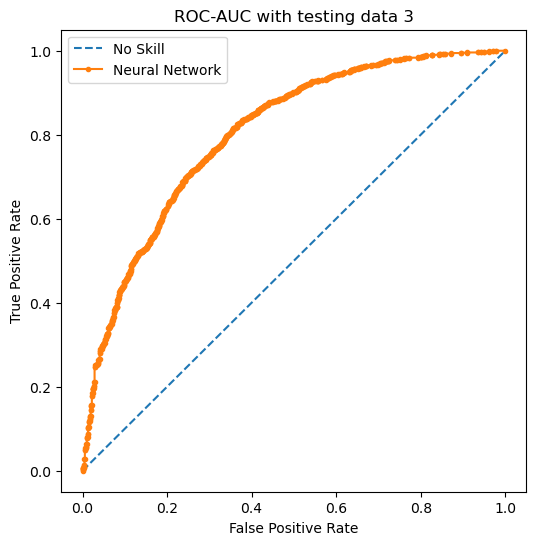

In [17]:
# param to search
nn_param = {
    "hidden_layer_sizes":[(10,10,10),(20,20,20),(30,30,30)],
    "activation":["relu"],   #, "tanh","relu"],   #, "logistic", "tanh", "relu"],
    "solver":["adam"],
    
    "alpha":[.3,.5,.7],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    "learning_rate_init": [.01],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[True,False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal,nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_acd3189ba2a54649b9edd545e1365406/11335-140591394488720-70a03fc13af74881bd79226639e2584e.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_acd3189ba2a54649b9edd545e1365406/11335-140591394488720-70a03fc13af74881bd79226639e2584e.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_acd3189ba2a54649b9edd545e1365406/11335-140591394488720-70a03fc13af74881bd79226639e2584e.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55 30 55]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  1 ...  1  1  0]
 [ 1  0  0 ...  0  0  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_acd3189ba2a54649b9edd545e1365406/11335-140591394488720-70a03fc13af74881bd79226639e2584e.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)


Data 1 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=(30,), learning_rate_init=0.01,
              max_iter=500, random_state=7, shuffle=False)
Model AUC (with data 1) = 0.7502520813357076


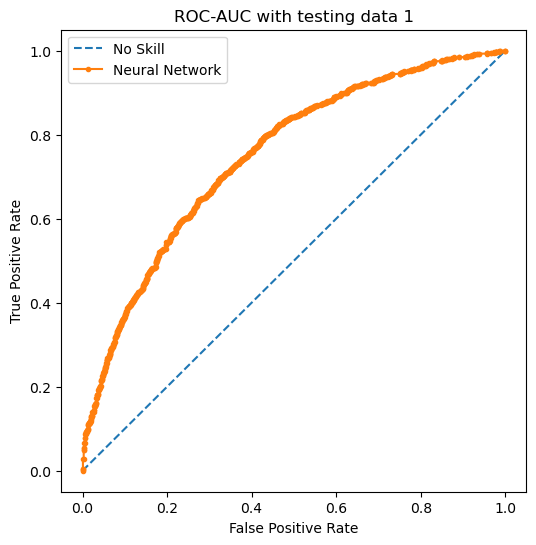

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_bf18712df6784654bd2f171028004c53/11335-140591394488720-a1390e0f512c4b00ab158216d3883085.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_bf18712df6784654bd2f171028004c53/11335-140591394488720-a1390e0f512c4b00ab158216d3883085.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_bf18712df6784654bd2f171028004c53/11335-140591394488720-a1390e0f512c4b00ab158216d3883085.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_bf18712df6784654bd2f171028004c53/11335-140591394488720-a1390e0f512c4b00ab158216d3883085.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_bf18712df6784654bd2f171028004c53/11335-140591394488720-a1390e0f512c4b00ab158216d3883085.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_bf18712df6784654bd2f171028004c53/11335-140591394488720-a1390e0f512c4b00ab158216d3883085.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_bf18712df6784654bd2f171028004c53/11335-140591394488720-a1390e0f512c4b00ab158216d3883085.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  1 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  0 ...  1  1  0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_bf18712df6784654bd2f171028004c53/11335-140591394488720-a1390e0f512c4b00ab158216d3883085.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[55 55 55 ... 55  0 55]
 [ 0  0  0 ...  3  3  1]
 [ 0  0  0 

Data 2 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=(30,), learning_rate_init=0.01,
              max_iter=500, random_state=7, shuffle=False)
Model AUC (with data 2) = 0.7480692789268881


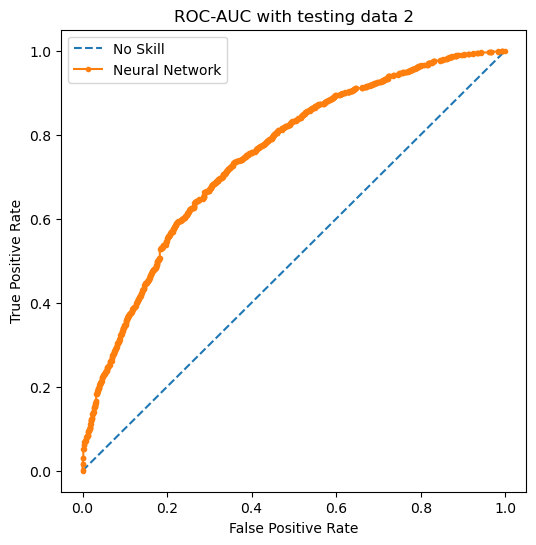

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_927c4054808f43ba84c0758af03b588c/11335-140591394488720-111588c9743a46b8a4029385bbbfd8ce.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] loaded from the file /var/folders/xg/8zx_jm0x3bddtdbddx13kckm0000gn/T/joblib_memmapping_folder_11335_47b8b61361d341288bd1678429b9c14a_927c4054808f43ba84c0758af03b588c/11335-140591394488720-111588c9743a46b8a4029385bbbfd8ce.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
/Users/andrewyaholkovsky/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[1 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 

Data 3 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=(30,), learning_rate_init=0.01,
              max_iter=500, random_state=7)
Model AUC (with data 3) = 0.8121391590439806


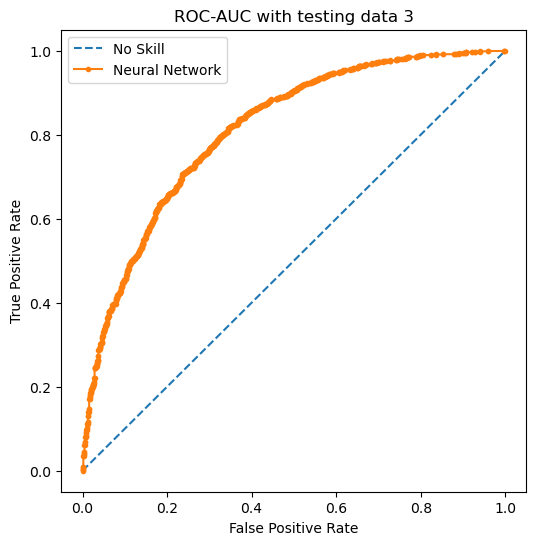

In [18]:
# param to search
nn_param = {
    "hidden_layer_sizes":[(5,),(10,),(20,),(30,)],
    "activation":["relu"],   #, "tanh","relu"],   #, "logistic", "tanh", "relu"],
    "solver":["adam"],
    
    "alpha":[.3,.5,.7],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    "learning_rate_init": [.01],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[True,False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal,nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

Data 1 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=(30,), learning_rate_init=0.01,
              max_iter=500, random_state=7, shuffle=False)
Model AUC (with data 1) = 0.7502520813357076


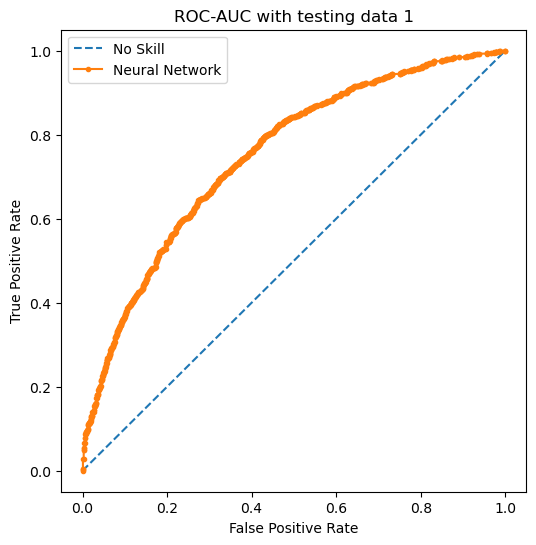

Data 2 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=(30,), learning_rate_init=0.01,
              max_iter=500, random_state=7, shuffle=False)
Model AUC (with data 2) = 0.7480692789268881


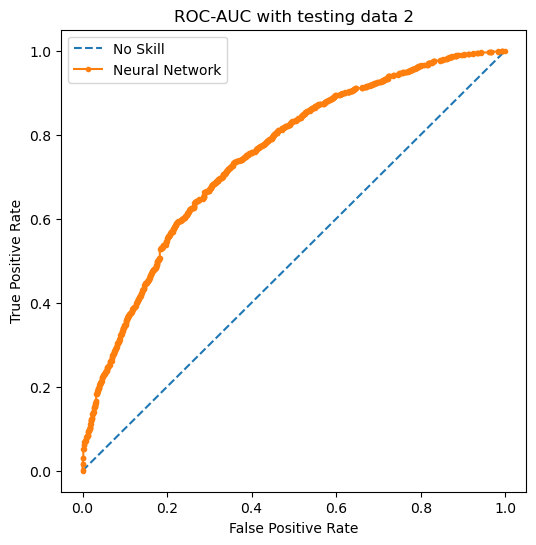

Data 3 best param: MLPClassifier(alpha=0.3, hidden_layer_sizes=(30,), learning_rate_init=0.01,
              max_iter=500, random_state=7)
Model AUC (with data 3) = 0.8121391590439806


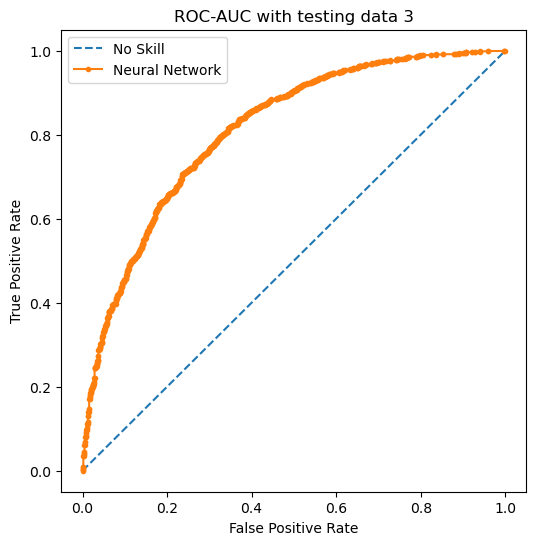

In [10]:
# param to search
nn_param = {
    "hidden_layer_sizes":[(5,),(10,),(20,),(30,)],
    "activation":["relu"],   #, "tanh","relu"],   #, "logistic", "tanh", "relu"],
    "solver":["adam"],
    
    "alpha":[.3,.5,.7],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    "learning_rate_init": [.01],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[True,False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal,nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

Data 1 best param: MLPClassifier(hidden_layer_sizes=(30,), learning_rate_init=0.01, max_iter=500,
              random_state=7)
Model AUC (with data 1) = 0.7986314044513442


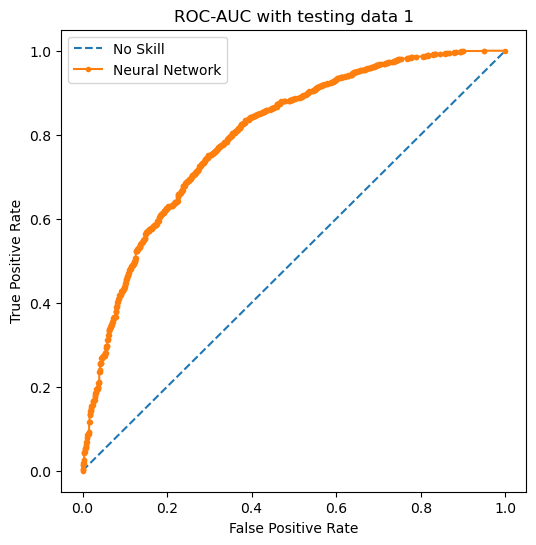

Data 2 best param: MLPClassifier(hidden_layer_sizes=(30,), learning_rate_init=0.01, max_iter=500,
              random_state=7)
Model AUC (with data 2) = 0.7739692885662246


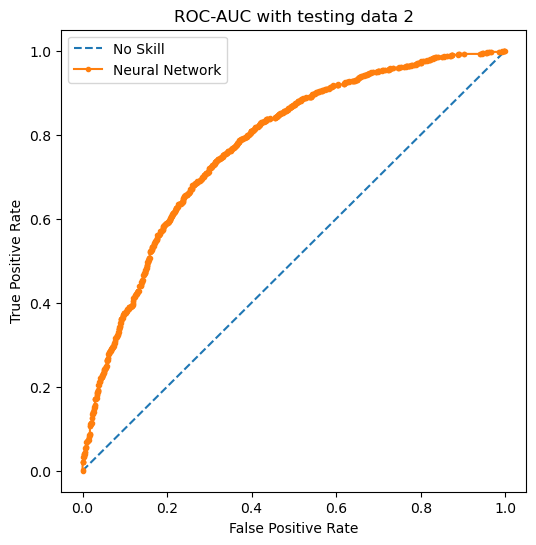

Data 3 best param: MLPClassifier(hidden_layer_sizes=(400,), learning_rate_init=0.01, max_iter=500,
              random_state=7, shuffle=False)
Model AUC (with data 3) = 0.8164032971604543


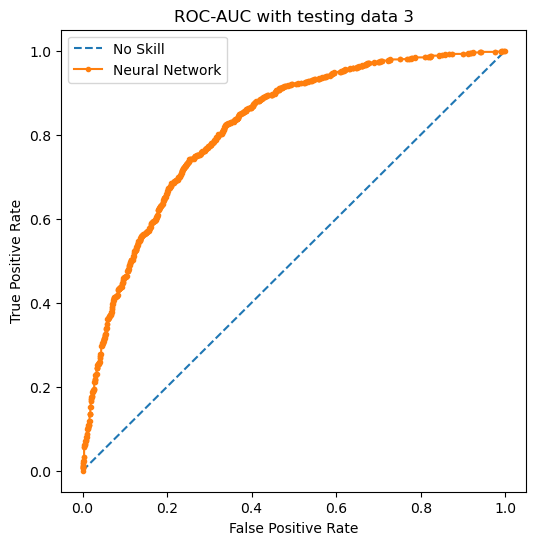

In [13]:
# param to search
nn_param = {
    "hidden_layer_sizes":[(30,),(200,),(400,)],
    "activation":["relu"],   #, "tanh","relu"],   #, "logistic", "tanh", "relu"],
    "solver":["adam"],
    
    #"alpha":[.01,.1,.3],
    
    "learning_rate":["constant"], #Only used when solver='sgd'
    "learning_rate_init": [.01],#Only used when solver='sgd' or 'adam'
    
    "max_iter":[500],
    "shuffle":[True,False],  #Only used when solver=’sgd’ or ‘adam’.
     }

for ind, df in enumerate([mode_allcat, mode_ordinal,nan_allcat]):
    
    # prepare data
    train, test = train_test_split(df, test_size=0.2, random_state=7)
    train_x = train.drop(["Y"], axis=1)
    test_x = test.drop(["Y"], axis=1)
    train_y = np.ravel(train[["Y"]])
    test_y = np.ravel(test[["Y"]])
    
    nn = GridSearchCV(MLPClassifier(random_state=7), nn_param, n_jobs=-1, scoring='roc_auc', cv=4)
    
    nn.fit(train_x, train_y)
    
    print(f"Data {ind+1} best param: {nn.best_estimator_}")
    
    ## plot ROC AUC
    
    # get the probabilities for testing data
    y_prob = nn.predict_proba(test_x)[:, 1]
    # roc auc
    line = [0 for _ in range(len(test_y))] # making straight line in ROC AUC graph (random guessing)
    line_auc = roc_auc_score(test_y, line)
    model_auc = roc_auc_score(test_y, y_prob)
    print(f'Model AUC (with data {ind+1}) = {model_auc}') # see the AUC score of our model
    # generate the curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, line)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, y_prob)
    # plot the roc curve for the model
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, marker='.', label='Neural Network')
    # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-AUC with testing data {ind+1}')
    # show the legend
    ax.legend()
    # show the plot
    plt.show()

Best performing model above uses the nan_allcat dataset has an AUC of .816